In [1]:
from math import exp 
import numpy as np
from itertools import product
from copy import deepcopy

In [21]:
class Cell:
    def __init__(self,car_num = 0, av_num = 0, length = 0.2 , q_max = 1600, f_speed = 40, dt = 10, jam_density = 240, av_lane = False,scale_down = 1):
        """
        f_speed: km/h; length: km; jam_density: veh/km; q_max = veh/h
        """
        self.car_num = car_num; self.av_num = av_num
        if self.car_num == 0:
            self.av_ratio = 0
        else:
            self.av_ratio = self.av_num/self.car_num

        self.length = length; self.f_speed = f_speed; self.q_max = q_max*(1+0.5*self.av_ratio)
        self.dt = dt; self.jam_density = jam_density*(1+0.5*self.av_ratio)
        self.wave_speed = self.q_max/(self.jam_density-self.q_max/self.f_speed)
        self.av_lane = av_lane; self.q_max = q_max*(1+0.5*self.av_ratio)
        self.demand = 0; self.supply = 0; self.density = self.car_num/self.length
        self.scale_down = scale_down; self.left_flow = 0
        self.right_flow = 0; self.down_flow = 0
        self.left_prob = 0; self.right_prob = 0
        self.down_prob = 0; self.left_in = 0
        self.right_in = 0; self.up_in = 0
        self.exp_right_flow = 0 # 拟向右换道车辆数
        self.exp_left_flow = 0 # 拟向左换道车辆数
        self.exp_down_flow = 0 # 拟向下游的车辆数

    def update_variable(self,left_num=200,right_num=300,down_num=200):
        """
        :param left_num: 左侧元胞车辆数
        :param right_num: 右侧元胞车辆数
        :param down_num: 下游元胞车辆数
        :return: 
        """
        beta1 = -0.4; beta2 = 5; beta3 = -0.1; beta4 = 1
        self.density = self.car_num/self.length
        self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600 # 这个改动较大
        self.demand = max(0, min(self.q_max,self.wave_speed*(self.jam_density-self.density)))*self.dt/3600

    
        left_utility = beta1*(self.car_num-left_num)+beta2
        right_utility = beta1*(self.car_num-right_num) + beta2  
        down_utility = beta3*(self.car_num-down_num)  + beta4 - 0.4*max(0,16-down_num)

        self.left_prob = exp(-left_utility)/(exp(-left_utility)+exp(-right_utility)+exp(-down_utility))
        self.right_prob = exp(-right_utility)/(exp(-left_utility)+exp(-right_utility)+exp(-down_utility))
        self.down_prob =  exp(-down_utility)/(exp(-left_utility)+exp(-right_utility)+exp(-down_utility))
        # print(self.down_prob)
        self.exp_down_flow = self.down_prob*self.supply
        self.exp_right_flow = self.right_prob*self.supply # 本车道拟向右换道车辆数
        self.exp_left_flow = self.left_prob*self.supply # 本车道拟向右换道车辆数
        
        if self.av_lane:
            self.right_prob = 1-self.av_ratio
            self.down_prob = self.av_ratio


    def update_car_num(self,up_out,down_demand,left_lane_up_out,left_lane_demand,right_lane_up_out,right_lane_demand,right_lane_exp_left_flow,left_lane_exp_right_flow,right_two_lane_exp_left_flow,left_two_lane_exp_right_flow,up_av_ratio, left_av_ratio, right_av_ratio):
        """
        Args:
            right_av_ratio: 
            up_out: 上游元胞想要出来的车辆数
            down_demand: 下游元胞的需求
            left_lane_up_out: 左侧上游想要直行的车辆数
            left_lane_demand: 左侧元胞供给
            right_lane_up_out: 右侧上游想要直行的车辆数
            right_lane_demand: 右侧元胞供给
            right_lane_exp_left_flow: 右侧想要变道的车辆数
            left_lane_exp_right_flow: 左侧想要变道的车辆数
            right_two_lane_exp_left_flow: 右侧第二个车道往右侧车道换道的车辆数
            left_two_lane_exp_right_flow: 左侧第二个车道往左侧车道换道的车辆数
            up_av_ratio: 
            left_av_ratio: 

        Returns:
        """
        # 三个cell进来的车辆数 上游cell 左侧车道的cell 右侧车道的cell
        self.up_in = min(self.demand,up_out) # 当前车道上游元胞向下走的车辆数
        if right_lane_exp_left_flow+left_lane_exp_right_flow>0:          
            self.right_in = min(right_lane_exp_left_flow/(right_lane_exp_left_flow+left_lane_exp_right_flow)*(self.demand-self.up_in), right_lane_exp_left_flow)
            self.left_in = min(left_lane_exp_right_flow/(right_lane_exp_left_flow+left_lane_exp_right_flow)*(self.demand-self.up_in), left_lane_exp_right_flow)
        else:
            self.right_in = 0; self.left_in = 0
       # 需要根据有多少车换道、直行到当前cell来确定换道对supply的影响；目的：体现出换道多交通的负效用
        if self.right_in+self.left_in+self.up_in>0:
            lc_ratio = (self.right_in+ self.left_in)/(self.right_in+self.left_in+self.up_in)
        else:
            lc_ratio = 0
        self.demand = self.demand * (1-lc_ratio*0.2) # 举例子
      # --------------------------------------------------------------------
        
        
        right_up_in = min(right_lane_demand, right_lane_up_out) # 右侧车道元胞直行车辆数
        left_up_in = min(left_lane_demand, left_lane_up_out) # 左侧车道元胞直行车辆数

        # 本cell朝三个方向出去的车辆数
        self.down_flow = min(down_demand,self.down_prob*self.car_num)
        if self.exp_right_flow+right_two_lane_exp_left_flow >0:
            self.right_flow = min(self.exp_right_flow/(self.exp_right_flow+right_two_lane_exp_left_flow)*(right_lane_demand-right_up_in) , self.exp_right_flow)
        else:
            self.right_flow = 0
        
        if self.exp_left_flow+left_two_lane_exp_right_flow > 0:
            self.left_flow = min(self.exp_left_flow/(self.exp_left_flow+left_two_lane_exp_right_flow)*(left_lane_demand-left_up_in) , self.exp_left_flow)
        else:
            self.left_flow = 0
            
    
    
    # 更新该元胞内部车辆数
        self.car_num = self.car_num + self.up_in + self.right_in + self.left_in - self.right_flow - self.down_flow - self.right_flow
        if not self.av_lane:
            self.av_num = (self.car_num-self.right_flow-self.down_flow-self.right_flow)*self.av_ratio + self.up_in*up_av_ratio + self.right_in*right_av_ratio + self.left_in*left_av_ratio 
        else:
            self.av_num = (self.car_num-self.down_flow)*self.av_ratio + self.up_in*up_av_ratio + self.right_in

        if self.car_num == 0:
            self.av_ratio = 0
        else:
            self.av_ratio = self.av_num/self.car_num
            
        
        self.wave_speed = self.q_max/(self.jam_density-self.q_max/self.f_speed)
        self.q_max = self.q_max*(1+0.5*self.av_ratio)
        # print(self.car_num)

class source:
    def __init__(self,car_num=30,av_num = 0, q_max=1600,f_speed = 40,length = 0.2,dt = 10,av_ratio = 0):
            self.car_num = car_num
            self.length = length
            self.q_max = q_max
            self.f_speed = f_speed
            self.density = self.car_num/self.length
            self.dt = dt
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600
            self.exp_down_flow = self.supply # source只往下走，不换道，因此，期望能往下的流量就是他的供给
            self.down_flow = self.supply # 实际的流量初始化是不知道的，是和下游相关的，需要update_variable
            self.av_num = av_num
            self.av_ratio = av_ratio
        
        
    def update_variable(self,input_flow, av_input,down_demand):
            self.down_flow = min(self.supply, down_demand)
            self.car_num = self.car_num + input_flow - self.down_flow
            self.av_num = self.av_num + av_input - self.down_flow*self.av_ratio
            self.av_ratio = self.av_num/self.car_num
            self.density = self.car_num/self.length
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600
           
        

class sink:
    def __init__(self):
        self.car_num = 0
        self.demand = 100000000000
        self.av_ratio = 0



In [163]:
class Agent():
    def __init__(self,lane_num, cell_num, ini_num, ini_av_num, ini_action, sim_time_step,sys_time,input,av_input): # 注意初始化的av_num
        """
        :param lane_num: 研究的范围内多少条道路
        :param cell_num: 研究范围内没条道路多少个cell
        :param initial_num: 每一个cell一开始多少车辆数，比如我们仿真8:00-8:30，或者仿真8:30-9:00这个值不一样
        :param initial_action: 这个是说的哪些segement是av dedicated lane
        :param simulation_time: 仿真多少个时间步
        :param input: 输入流量
        """
        self.lane_num = lane_num
        self.cell_num = cell_num
        self.ini_num = ini_num
        self.ini_action = ini_action
        self.sim_time_step = sim_time_step
        self.state1 = 0 # 这些状态自己定义哈
        self.state2 = 0
        self.state3 = 0
        self.reward = 0 # reward自己定义
        self.done = False # 是否结束
        self.sys_time = sys_time
        self.num_record = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])
        self.av_ratio_record  = np.zeros([self.lane_num, self.cell_num,self.sim_time_step])
        self.input = input # input 应该是lane num * time step的东西
        self.av_input = av_input

    def run(self):
        # 初始化网络----------------------------------------------------------------
        Road = [[[] for j in range(self.cell_num)] for i in range(self.lane_num)]
        for i,j in product(range(self.lane_num),range(self.cell_num-2)):
            Road[i][j+1] = Cell(car_num = ini_num[i][j],av_lane=self.ini_action[i][j])
            print(Road[0][j+1].av_lane)
        for i in range(self.lane_num):
            Road[i][0] = source(car_num=0,av_num=0)
            Road[i][-1] = sink()
        # -------------------------------------------------------------------------

        for t in range(self.sim_time_step):
            Road_copy = deepcopy(Road) # 在更新过程中有一些先后顺序，需要破坏Road的性质，因此先拷贝一份,因为要改变Road部分元素，所以要用deepcopy
            for i,j in product(range(self.lane_num),range(self.cell_num)):
                self.num_record[i][j][t] = Road_copy[i][j].car_num
                self.av_ratio_record[i][j][t] = Road_copy[i][j].av_ratio
                
            
            for i in range(self.lane_num):
                Road[i][0].update_variable(input_flow = input[i][t],down_demand = Road[i][1].demand,av_input = av_input[i][t]) # 此处用Road和Road_copy并无区别，暂且用Road
                
                for _j in range(self.cell_num-2):
                    j = _j + 1
                    if i == 0:
                        Road[i][j].update_variable(left_num = 0,right_num=Road_copy[i+1][j].car_num,down_num=Road_copy[i][j+1].car_num)
                        Road[i][j].update_car_num(up_out = Road_copy[i][j-1].supply,
                                                                  down_demand = Road_copy[i][j+1].demand,
                                                                  left_lane_up_out = 0,
                                                                  left_lane_demand = 0,
                                                                  right_lane_up_out = Road_copy[i+1][j-1].down_flow,
                                                                  right_lane_demand = Road_copy[i+1][j].demand,
                                                                  right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                                  left_lane_exp_right_flow = 0,
                                                                  right_two_lane_exp_left_flow = Road_copy[i+2][j].exp_left_flow,
                                                                  left_two_lane_exp_right_flow = 0,
                                                                  up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                                  left_av_ratio = 0,
                                                                  right_av_ratio = Road_copy[i+1][j].av_ratio)
                    if i == 1:
                        Road[i][j].update_variable(left_num = Road_copy[i-1][j].car_num,right_num=Road_copy[i+1][j].car_num,down_num=Road_copy[i][j+1].car_num)
                        Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_lane_up_out = Road_copy[i-1][j-1].down_flow,
                                                              left_lane_demand = Road_copy[i-1][j].demand,
                                                              right_lane_up_out = Road_copy[i+1][j-1].down_flow,
                                                              right_lane_demand = Road_copy[i+1][j].demand,
                                                              right_lane_exp_left_flow = Road_copy[i+1][j].exp_left_flow,
                                                              left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                              right_two_lane_exp_left_flow = 0,
                                                              left_two_lane_exp_right_flow = 0,
                                                              up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                              left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                              right_av_ratio = Road_copy[i+1][j].av_ratio)
                    if i == 2:
                        Road[i][j].update_variable(left_num = Road_copy[i-1][j].car_num,right_num=0,down_num=Road_copy[i][j+1].car_num)
                        Road[i][j].update_car_num(up_out = Road_copy[i][j-1].exp_down_flow,
                                                              down_demand = Road_copy[i][j+1].demand,
                                                              left_lane_up_out = Road_copy[i-1][j-1].down_flow,
                                                              left_lane_demand = Road_copy[i-1][j].demand,
                                                              right_lane_up_out = 0,
                                                              right_lane_demand = 0,
                                                              right_lane_exp_left_flow = 0,
                                                              left_lane_exp_right_flow = Road_copy[i-1][j].exp_right_flow,
                                                              right_two_lane_exp_left_flow = 0,
                                                              left_two_lane_exp_right_flow = Road_copy[i-2][j].exp_right_flow,
                                                              up_av_ratio = Road_copy[i][j-1].av_ratio,
                                                              left_av_ratio = Road_copy[i-1][j].av_ratio,
                                                              right_av_ratio = 0)
                
                    
                        
                        
                    
                 
                    
                    
                    
    
                            
                            
                             

In [164]:
ini_num = np.random.poisson(40 , size=(3, 100))
ini_av = np.random.poisson(20 , size=(3, 100))
for i,j in product(range(3),range(100)):
    ini_av[i][j] = min(ini_av[i][j],ini_num[i][j])
    
ini_action = np.zeros([3,100])
for j in range(100):
    ini_action[0][j] = 1
    


input = np.random.poisson(40 , size=(3, 100)) # 道路和时间

p = 0.4
av_input = np.random.poisson(25*p , size=(3, 100))
for i,t in product(range(3),range(100)):
    av_input[i][t] = min(av_input[i][t],input[i][t])




In [165]:
ini_av[1][11]

19

In [166]:
ini_num

array([[53, 37, 36, 45, 32, 31, 30, 42, 40, 38, 39, 48, 42, 50, 56, 29,
        47, 38, 43, 32, 37, 35, 30, 37, 36, 36, 31, 49, 49, 37, 51, 51,
        46, 50, 48, 45, 39, 30, 39, 49, 41, 41, 50, 38, 42, 56, 31, 35,
        48, 29, 42, 40, 40, 44, 38, 37, 44, 51, 43, 35, 42, 35, 39, 41,
        44, 40, 43, 43, 38, 30, 42, 44, 44, 34, 44, 38, 41, 39, 34, 36,
        39, 46, 45, 44, 40, 41, 51, 37, 34, 29, 52, 39, 38, 38, 40, 46,
        35, 37, 48, 32],
       [51, 54, 28, 33, 40, 38, 36, 48, 37, 41, 34, 39, 49, 50, 31, 50,
        37, 35, 41, 48, 45, 51, 32, 34, 31, 43, 35, 39, 32, 38, 41, 38,
        58, 32, 48, 36, 44, 31, 37, 36, 40, 44, 42, 37, 41, 28, 46, 31,
        33, 38, 50, 42, 34, 30, 43, 41, 40, 33, 58, 38, 42, 47, 33, 51,
        40, 42, 52, 41, 39, 38, 38, 38, 49, 33, 49, 40, 43, 52, 34, 41,
        36, 49, 62, 36, 44, 42, 54, 30, 49, 44, 41, 37, 36, 37, 38, 47,
        38, 46, 38, 41],
       [40, 43, 31, 42, 42, 33, 42, 38, 46, 49, 41, 41, 45, 45, 38, 41,
        48, 47

In [167]:
agent = Agent(lane_num=3,cell_num=100,ini_num = ini_num,ini_av_num=ini_av,ini_action = ini_action,sim_time_step=100,sys_time=0,input=input,av_input = av_input)


In [168]:
agent.run()

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [146]:
import matplotlib.pyplot as plt 

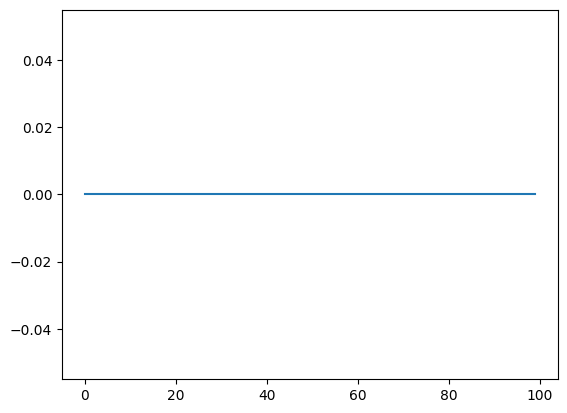

In [153]:
plt.plot(agent.av_ratio_record[1][0:99][90])
# plt.hlines(48,0,100,color='red',ls = '--')
# plt.hlines(25,0,100,color='blue',ls='-.')

In [156]:
agent.num_record[1]

array([[0.00000000e+00, 2.70000000e+01, 5.90000000e+01, ...,
        3.68219672e+03, 3.72364116e+03, 3.75208561e+03],
       [5.00000000e+01, 5.00000000e+01, 4.57777778e+01, ...,
        4.58412130e+00, 4.58513296e+00, 4.58627759e+00],
       [4.00000000e+01, 4.00000000e+01, 3.97735356e+01, ...,
        3.69859998e+01, 3.69909314e+01, 3.69962637e+01],
       ...,
       [3.60000000e+01, 3.60000000e+01, 3.66653269e+01, ...,
        3.55775212e+00, 3.50909583e+00, 3.45450666e+00],
       [4.20000000e+01, 2.15147746e-04, 6.30268090e-01, ...,
        3.00901979e+00, 2.97992285e+00, 2.95461766e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [343]:
supply = []
demand = []
q = int(1600*1.5)
jam = int(240*1.5)
w = q/(jam-q/40)
for i in range(0,jam):
    k = i 
    supply.append(min(q,40*k))
    demand.append(min(q,w*(jam-k)))
# supply =max(0, min(self.q_max,1000*self.density * self.f_speed * self.dt / 3600)* self.length/1000)
#     self.demand =max(0, min(self.q_max,1000*(self.jam_density - self.density) * self.wave_speed * self.dt / 3600) * self.length/1000)


# self.q_max/(self.jam_density-self.q_max/self.f_speed)


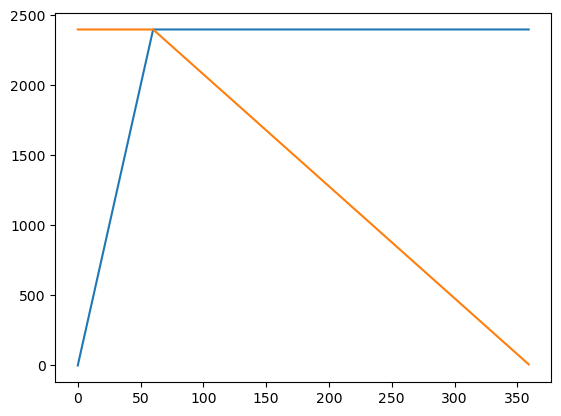

In [344]:
plt.plot(supply)

plt.plot(demand)

In [85]:
class source:
    def __init__(self,car_num,q_max=1600,f_speed = 40,length = 0.2,dt = 10):
        self.car_num = car_num
        self.length = length
        self.q_max = q_max
        self.f_speed = f_speed
        self.density = self.car_num/self.length
        self.dt = dt 
        self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600 
    def variable_update(self,input_flow,down_demand):
            self.car_num = self.car_num + input_flow - min(self.supply, down_demand)
            self.density = self.car_num/self.length
            self.supply = max(0, min(self.q_max,self.f_speed*self.density))*self.dt/3600


class sink:
    def __init__(self):
        self.car_num = 0
        self.demand = 100000000000
        
        

In [8]:
from copy import deepcopy
a = [1,2,3]
b = deepcopy(a)
a[1] = 10

In [9]:
print(b)

[1, 2, 3]
